### LSTM-based Time-Series Model
- Predict future sensor readings in patients with parkinsons disease

In [202]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
# warning ignore
import warnings
warnings.filterwarnings('ignore')

##### Load dataset

In [203]:

df = pd.read_csv("../processed-data/cleaned-parkinsons-data.csv")


#### Encode categorical variables

In [204]:

label_encoders = {}
for col in ['Task']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Map DeviceLocation to numerical values
df["Device_Location"] = df["Device_Location"].map({"RightWrist": 0, "LeftWrist": 1})


#### Define Input and Target Features

In [205]:

# Define input features (past movement + metadata) and target (future movement)
features = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Time', 'Condition']
target = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']  # Predict future movement


#### Scale Features and Segment Data

In [206]:
# Sort data by Patient ID and time
df = df.sort_values(by=['Patient_id'])

# initialize lists to store segmented data
train_data_list = []
test_data_list = []

# Split and normalize per patient to prevent data leakage
scaler = MinMaxScaler()

for patient_id, patient_df in df.groupby('Patient_id'):
    split_index = round(int(len(patient_df) * 0.8))  # 80% train, 20% test
    
    train_patient = patient_df.iloc[:split_index]
    test_patient = patient_df.iloc[split_index:]

    # Normalize per patient
    train_patient[features] = scaler.fit_transform(train_patient[features])
    test_patient[features] = scaler.transform(test_patient[features])

    train_data_list.append(train_patient)
    test_data_list.append(test_patient)

# Combine segmented data
train_data = pd.concat(train_data_list)
test_data = pd.concat(test_data_list)

#### Create Data Sequence

In [207]:


# Function to create sequences for each patient's data
sequence_length = 10
def create_sequences(data, sequence_length=sequence_length):
    sequences = []
    labels = []
    
    for patient_id, patient_df in data.groupby('Patient_id'):
        patient_data = patient_df.reset_index(drop=True)  # Reset index for sequential slicing
        
        for i in range(len(patient_data) - sequence_length):
            seq = patient_data.iloc[i:i+sequence_length][features].values
            label = patient_data.iloc[i+sequence_length][target].values  # Predict next step
            sequences.append(seq)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length=sequence_length)



#### Define LSTM Model

In [208]:
# Define LSTM model

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features)))),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(32, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(16, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(len(target), activation='linear')  # Predict movement values
])

In [209]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.8364 - mae: 0.9259 - val_loss: 0.0669 - val_mae: 0.2101
Epoch 2/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0559 - mae: 0.1863 - val_loss: 0.0302 - val_mae: 0.1293
Epoch 3/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0356 - mae: 0.1470 - val_loss: 0.0230 - val_mae: 0.1081
Epoch 4/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0319 - mae: 0.1379 - val_loss: 0.0201 - val_mae: 0.0995
Epoch 5/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0305 - mae: 0.1342 - val_loss: 0.0188 - val_mae: 0.0950
Epoch 6/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0295 - mae: 0.1317 - val_loss: 0.0187 - val_mae: 0.0959
Epoch 7/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0289 - mae: 0.1303 - val_loss: 0.0179 - val_mae: 0.0928
Epoch 8/30
6528/6528 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0287 - mae: 0.1295 - val_loss: 0.0177 - val_mae: 0.0927
Epoch 9/30
6528/6528 ━━━━━━━━━━━

#### Evaluate Model

In [210]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")
print(f"Test Loss: {loss:.2f}")

738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0176 - mae: 0.0919
Test MAE: 0.09
Test Loss: 0.02


#### Visualize Result

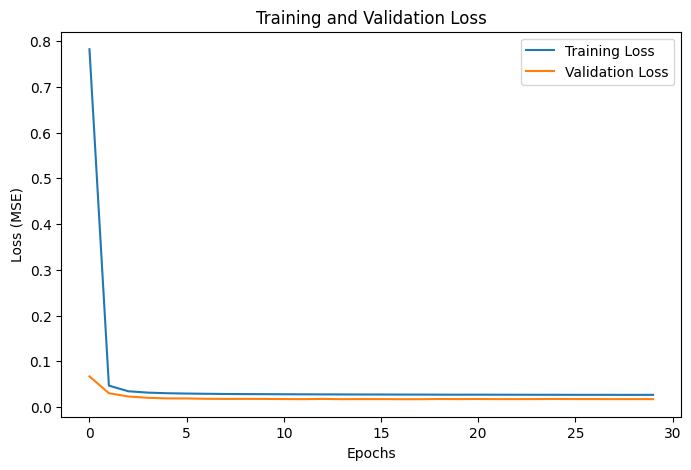

In [211]:
## visualize the model
# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Save prediction for Visualization

In [212]:
# Predict movement variability progression
y_pred = model.predict(X_test)
# Convert X_test to a DataFrame for comparison
X_test_df = pd.DataFrame(X_test[:, -1, :], columns=[f'{col}' for col in features])
X_test_df.reset_index(drop=True, inplace=True)

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=[f'Predicted_{col}' for col in target])

# Combine input data with predictions
comparison_df = pd.concat([X_test_df, y_pred_df], axis=1)
# sort by time
comparison_df = comparison_df.sort_values(by=['Time'])

# Save the updated dataset with input vs. predicted data
comparison_df.to_csv("../processed-data/movement_variability_pred.csv", index=False)

print("Comparison dataset saved successfully.")


738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Comparison dataset saved successfully.
